Import all Modules

In [105]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import os
import os

# Import Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import Pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split


Displaying Data

In [106]:
# Load the dataset
current_path = os.getcwd()
parent_folder = os.path.dirname(current_path)
data_file_path = os.path.join(parent_folder, "Data", "Student_performance_data.csv")
df = pd.read_csv(str(data_file_path))

# Load train and test indices
train_index_path = os.path.join(parent_folder, "Data", "train_index.csv")
test_index_path = os.path.join(parent_folder, "Data", "test_index.csv")
train_index = pd.read_csv(train_index_path, header=None).iloc[:, 0].tolist()
test_index = pd.read_csv(test_index_path, header=None).iloc[:, 0].tolist()

# Feature engineering (same as before)
df['Attendance'] = 1 - (df['Absences'] / 30)
df['Activity'] = df[['Extracurricular', 'Music', 'Sports', 'Volunteering']].sum(axis=1)
df['StudyTimeNorm'] = df['StudyTimeWeekly'] / 20
df['Engagement'] = (df['Attendance'] * 0.4 + df['Activity'] * 0.3 + df['StudyTimeNorm'] * 0.3)

# Separate features and labels
X = df.drop('GradeClass', axis=1)
y = df['GradeClass']

Exploratory Data Analysis (EDA)

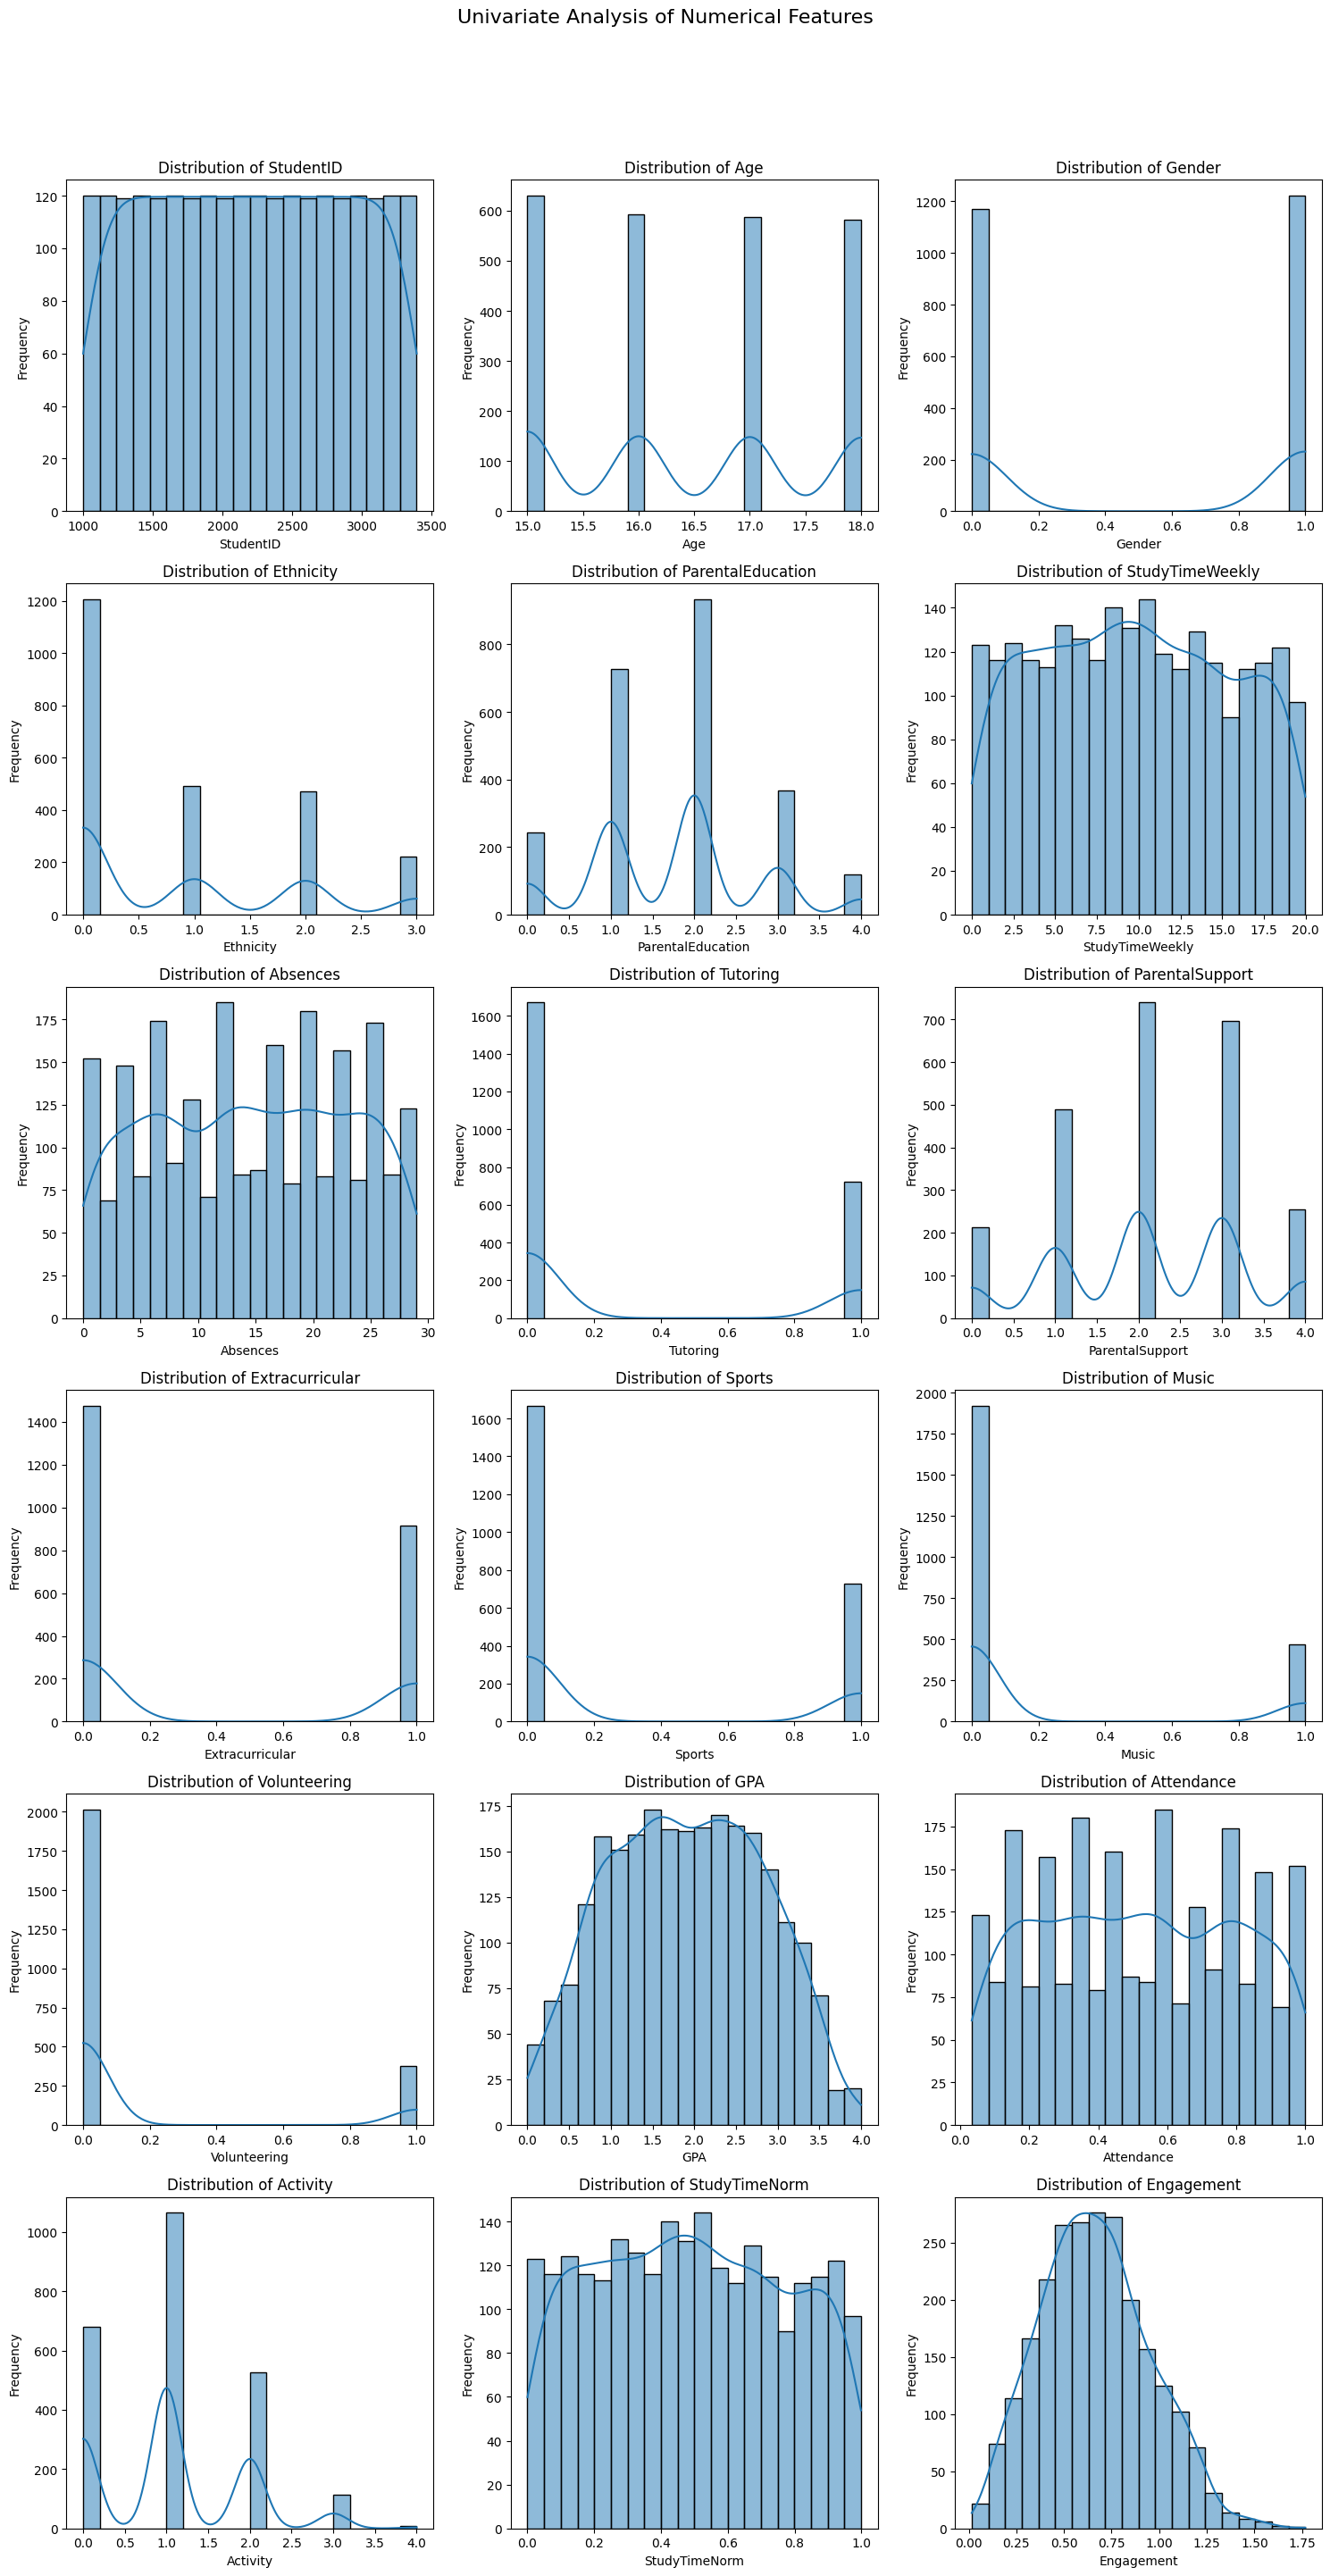

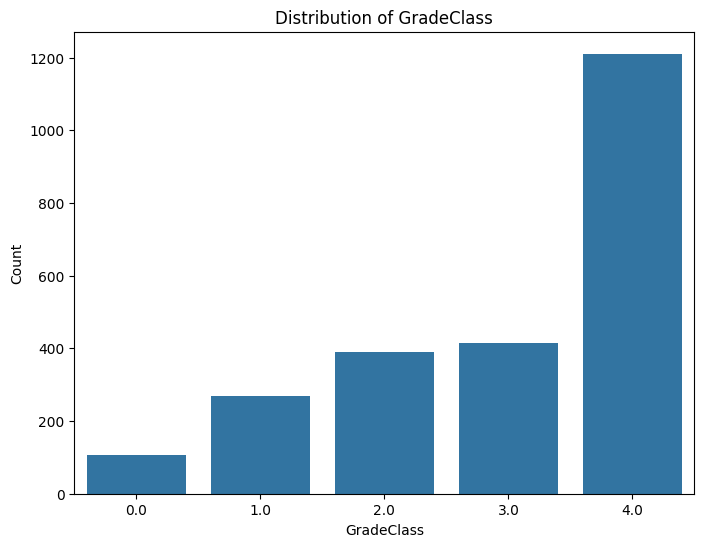

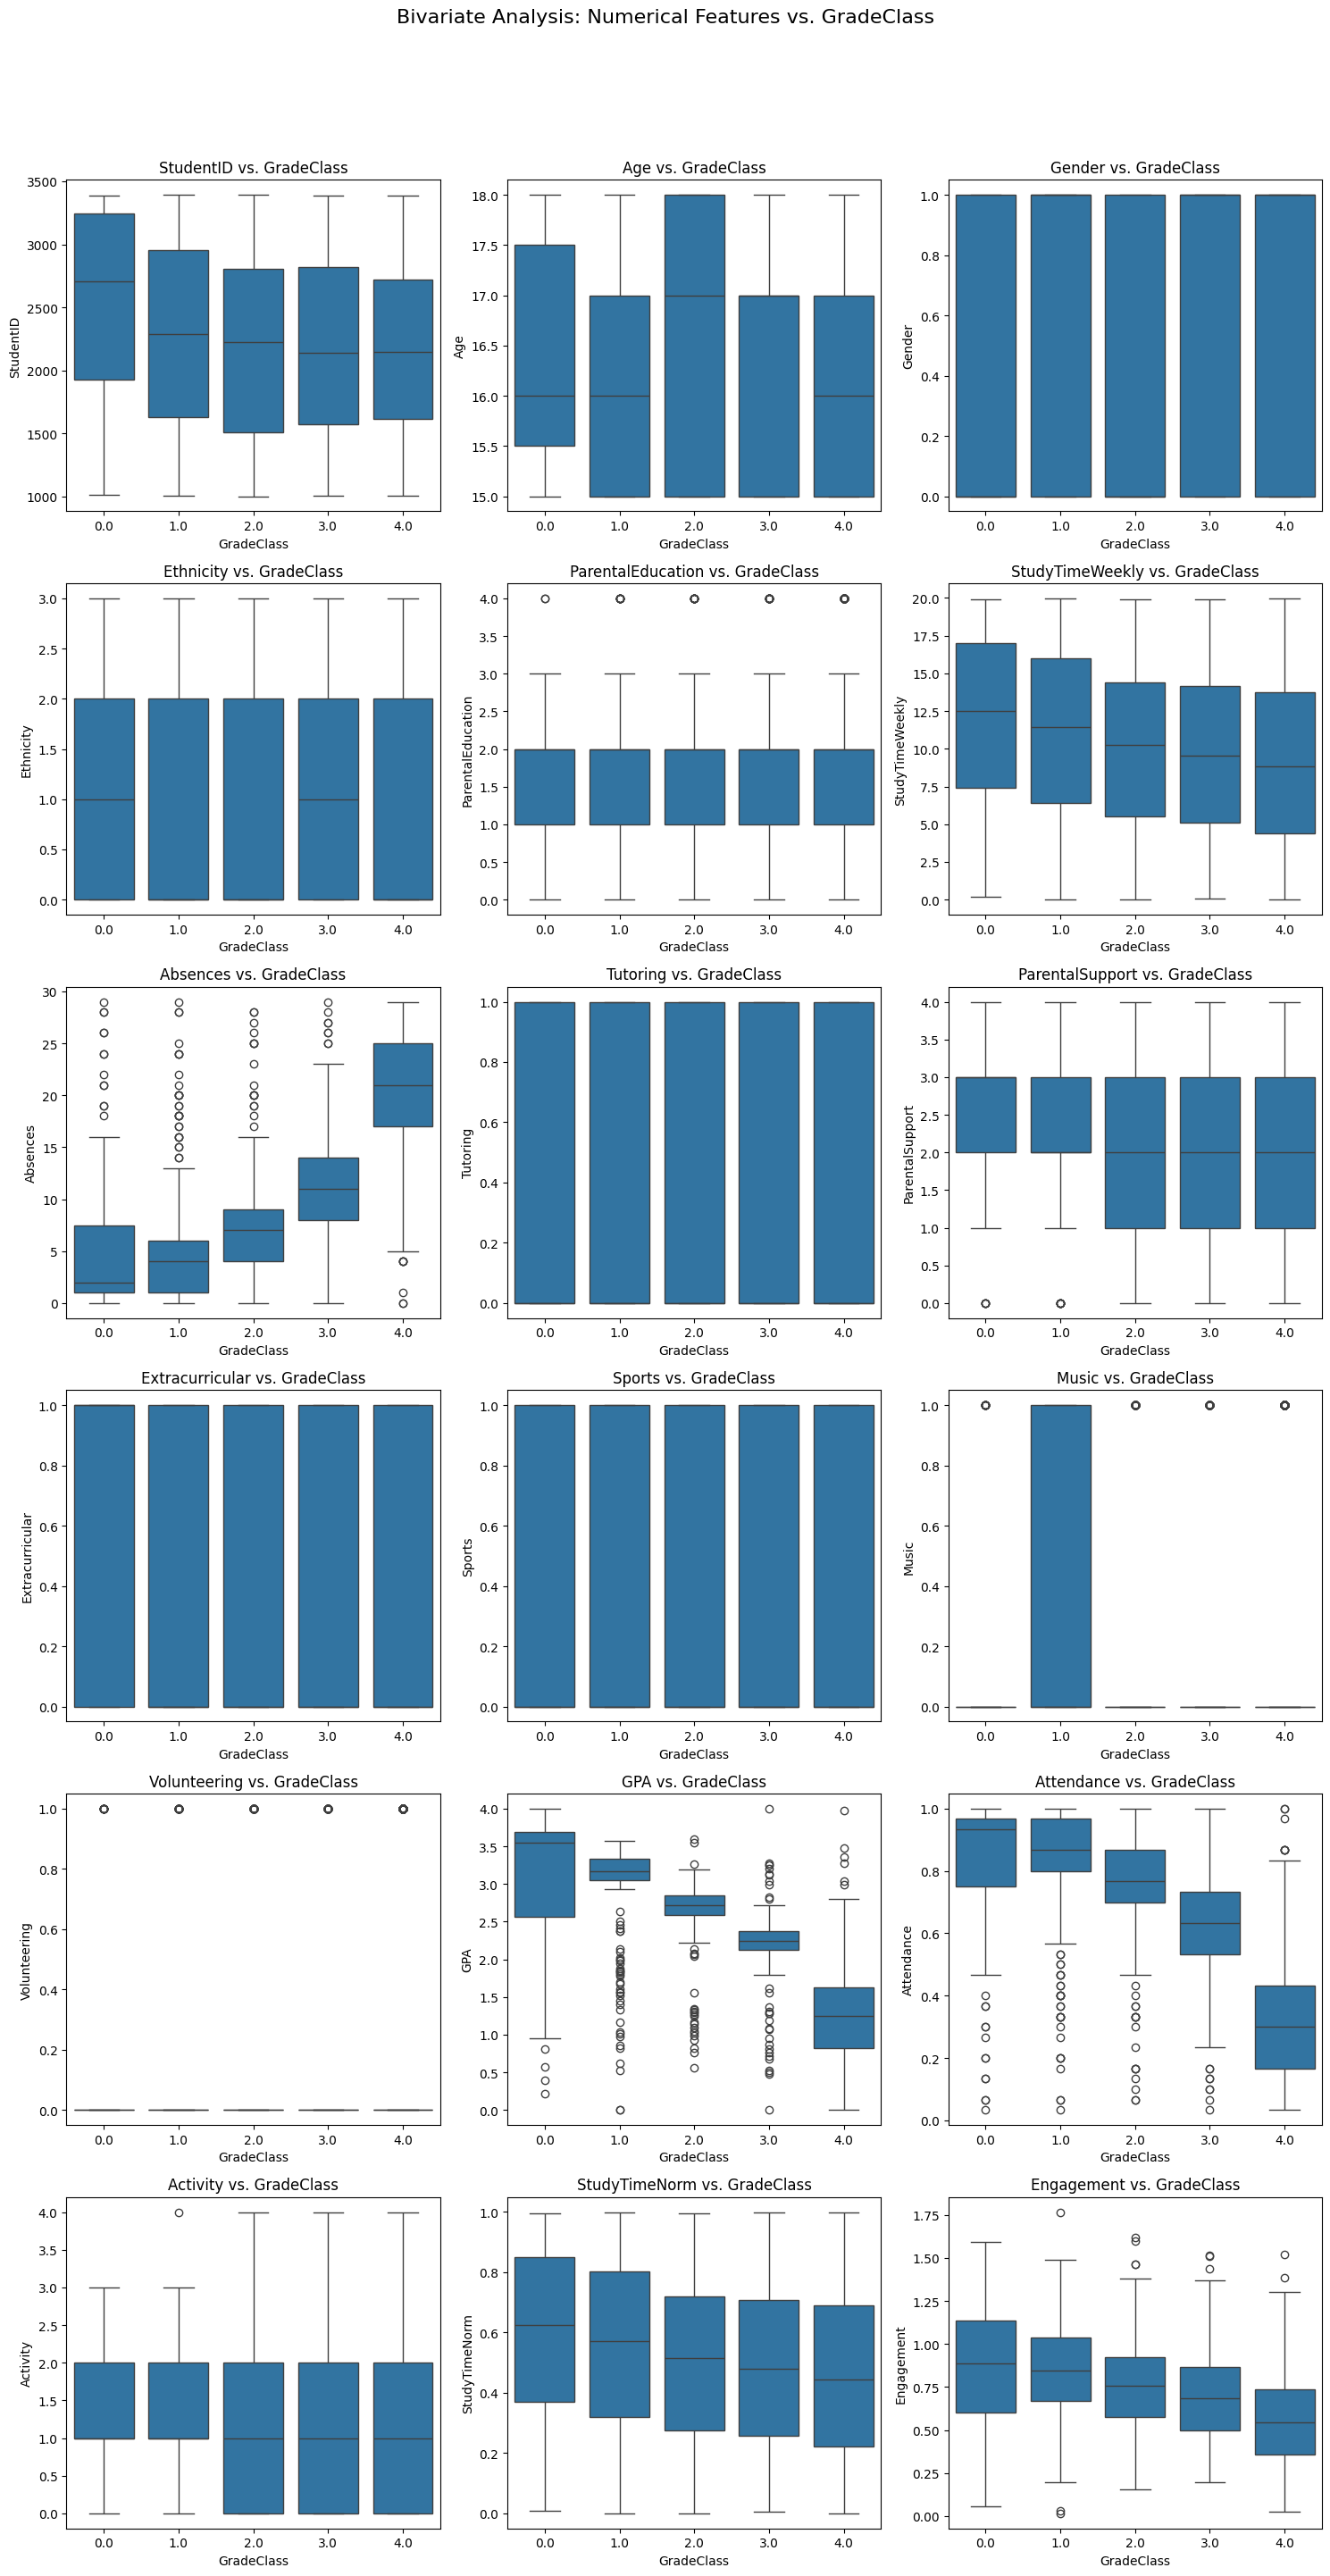

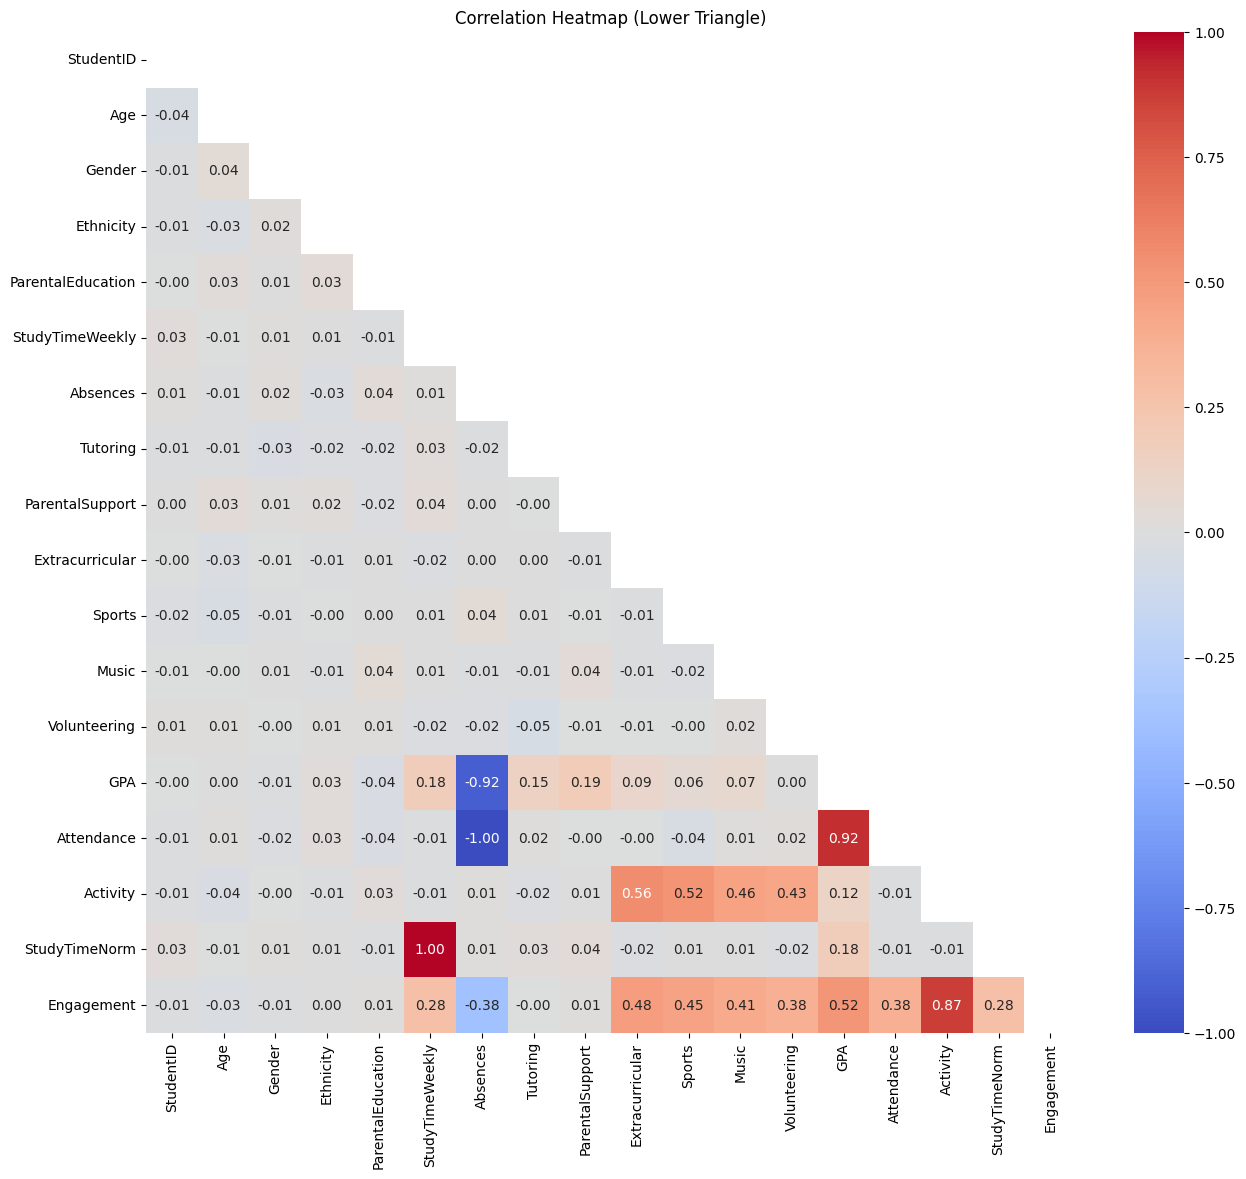

In [107]:
#  Exploratory Data Analysis (EDA)

def univariate_analysis(X, y):
    """
    Performs univariate analysis on numerical features and the target variable.

    Args:
        X (pd.DataFrame): The feature DataFrame.
        y (pd.Series): The target Series.
    """

    #  Univariate Analysis of Numerical Features
    numerical_features = X.select_dtypes(include=np.number).columns
    num_cols = 3  # Number of columns in the plot grid
    num_rows = (len(numerical_features) + num_cols - 1) // num_cols  # Calculate number of rows

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure height dynamically
    for i, feature in enumerate(numerical_features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(X[feature], bins=20, kde=True)  # Use histplot for better visuals
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
    plt.suptitle('Univariate Analysis of Numerical Features', y=0.99, fontsize=16)  # Move suptitle to the end
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlap
    plt.show()

    #  Univariate Analysis of Target Variable
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y)
    plt.title('Distribution of GradeClass')
    plt.xlabel('GradeClass')
    plt.ylabel('Count')
    plt.show()


def bivariate_analysis(X, y):
    """
    Performs bivariate analysis between numerical features and the target variable.

    Args:
        X (pd.DataFrame): The feature DataFrame.
        y (pd.Series): The target Series.
    """

    #  Bivariate Analysis: Numerical Features vs. GradeClass (Boxplots)
    numerical_features = X.select_dtypes(include=np.number).columns
    num_cols = 3
    num_rows = (len(numerical_features) + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for i, feature in enumerate(numerical_features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x=y, y=X[feature])
        plt.title(f'{feature} vs. GradeClass')
        plt.xlabel('GradeClass')
        plt.ylabel(feature)
    plt.suptitle('Bivariate Analysis: Numerical Features vs. GradeClass', y=0.99, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    #  Bivariate Analysis: Correlation Heatmap (Lower Triangle)
    corr_matrix = X.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask for the upper triangle
    plt.figure(figsize=(15, 13))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10}, mask=mask) # Apply the mask
    plt.title('Correlation Heatmap (Lower Triangle)')
    plt.show()


#  Main EDA Execution
univariate_analysis(X, y)
bivariate_analysis(X, y)

Create Train and Test Sets

In [108]:
# Create train and test sets using the loaded indices
X_train = X.iloc[train_index]
X_test = X.iloc[test_index]
y_train = y.iloc[train_index]
y_test = y.iloc[test_index]

print("X_train head:")
print(X_train.head())

print("\nData shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train head:
      StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
1764       2765   15       1          1                  1         9.247229   
1479       2480   18       0          0                  4         8.978234   
1529       2530   18       0          0                  1        10.088421   
2196       3197   17       1          1                  1         1.001291   
2146       3147   15       0          0                  1        12.324485   

      Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
1764        21         1                2                0       1      0   
1479         3         0                2                0       1      0   
1529        13         0                1                0       0      0   
2196         0         0                2                0       0      0   
2146         0         0                1                1       0      0   

      Volunteering       GPA  Attendance  Activi

Processing and Tensors

In [109]:
# Scale numerical features -  FIT only on training data, TRANSFORM both
numerical_cols = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])  # Apply same scaling to test

# Encode the target variable - ONLY FIT on the training data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())
y_test_encoded = label_encoder.transform(y_test.values.ravel())

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

Create TensorDatasets and DataLoaders

In [110]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 128   # Experiment with this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Validation loader (create if needed, or load a separate validation set)
# For simplicity, I'll resplit train_dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[int(len(train_dataset)*0.85),len(train_dataset) - int(len(train_dataset)*0.85)])
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Define the Neural Network Model

In [111]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

input_size = X_train_tensor.shape[1]
num_classes = len(label_encoder.classes_)
model = Net(input_size, num_classes)

Define Loss Function

In [112]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train the Model

Epoch [1/300], Train Loss: 1.0032, Val Loss: 1.0350
Epoch [2/300], Train Loss: 0.8934, Val Loss: 0.9348
Epoch [3/300], Train Loss: 0.7166, Val Loss: 0.7576
Epoch [4/300], Train Loss: 0.6257, Val Loss: 0.6715
Epoch [5/300], Train Loss: 0.5716, Val Loss: 0.6147
Epoch [6/300], Train Loss: 0.5089, Val Loss: 0.5674
Epoch [7/300], Train Loss: 0.4984, Val Loss: 0.5512
Epoch [8/300], Train Loss: 0.4691, Val Loss: 0.5218
Epoch [9/300], Train Loss: 0.4505, Val Loss: 0.5018
Epoch [10/300], Train Loss: 0.4322, Val Loss: 0.4851
Epoch [11/300], Train Loss: 0.4243, Val Loss: 0.4753
Epoch [12/300], Train Loss: 0.4163, Val Loss: 0.4692
Epoch [13/300], Train Loss: 0.4187, Val Loss: 0.4682
Epoch [14/300], Train Loss: 0.4102, Val Loss: 0.4605
Epoch [15/300], Train Loss: 0.3954, Val Loss: 0.4443
Epoch [16/300], Train Loss: 0.3889, Val Loss: 0.4462
Epoch [17/300], Train Loss: 0.3797, Val Loss: 0.4410
Epoch [18/300], Train Loss: 0.3759, Val Loss: 0.4161
Epoch [19/300], Train Loss: 0.3659, Val Loss: 0.4113
Ep

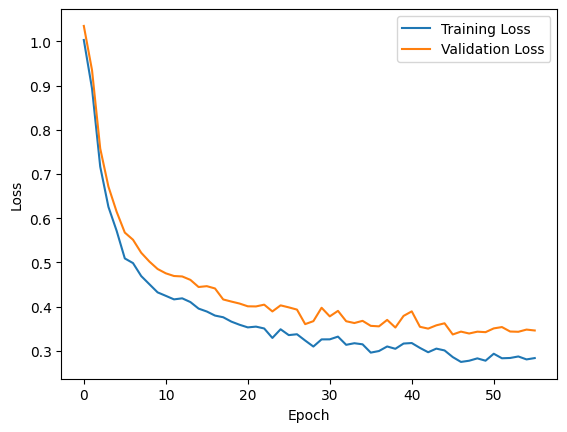

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.56      0.70        27
         1.0       0.76      0.74      0.75        46
         2.0       0.80      0.82      0.81        83
         3.0       0.83      0.78      0.81        69
         4.0       0.92      0.97      0.95       251

    accuracy                           0.87       476
   macro avg       0.85      0.77      0.80       476
weighted avg       0.87      0.87      0.87       476



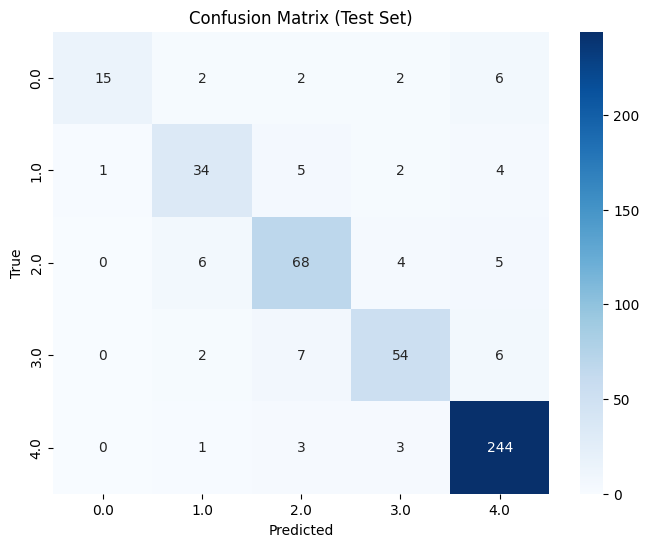

Model Evaluation Complete


In [113]:
num_epochs = 300
patience = 10
best_val_loss = float('inf')
no_improve_count = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_loss = sum(criterion(model(inputs), labels).item() for inputs, labels in train_loader) / len(train_loader)
        val_loss = sum(criterion(model(inputs), labels).item() for inputs, labels in val_loader) / len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), 'Neural_Network_Best_Model.pth')
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print('Early stopping!')
            model.load_state_dict(torch.load('Neural_Network_Best_Model.pth'))
            break

# Plotting Loss Curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation and Confusion Matrix (AFTER the training loop)
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    y_pred = np.array(y_pred, dtype=np.int64)
    y_true = np.array(y_true, dtype=np.int64)

    target_names = [str(cls) for cls in label_encoder.classes_]
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    print("Model Evaluation Complete")

Evaluate the Model

In [114]:
# Evaluate the Model
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))
    print("Accuracy:\n", accuracy_score(y_true, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.56      0.70        27
         1.0       0.76      0.74      0.75        46
         2.0       0.80      0.82      0.81        83
         3.0       0.83      0.78      0.81        69
         4.0       0.92      0.97      0.95       251

    accuracy                           0.87       476
   macro avg       0.85      0.77      0.80       476
weighted avg       0.87      0.87      0.87       476

Accuracy:
 0.8718487394957983
